In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Load Metro Link Bike Share data, the data consisted of the operations from the 3rd quarter, 2016 (July - September). Note that the service launched on July 7, 2016.

In [2]:
trip_data = pd.read_csv("data/MetroBikeShare_2016_Q3_trips.csv")
trip_data.head()

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,1912818,180,7/7/2016 4:17,7/7/2016 4:20,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass
1,1919661,1980,7/7/2016 6:00,7/7/2016 6:33,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass
2,1933383,300,7/7/2016 10:32,7/7/2016 10:37,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass
3,1944197,10860,7/7/2016 10:37,7/7/2016 13:38,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass
4,1940317,420,7/7/2016 12:51,7/7/2016 12:58,3032,34.049889,-118.25588,3032,34.049889,-118.25588,6674,0,Round Trip,Walk-up


In [3]:
trip_data.shape

(55439, 14)

As expected, nearly 60% of all trips pertained to "Monthly Pass" option. This option is the perfect choice for the local residents who commute regularly.

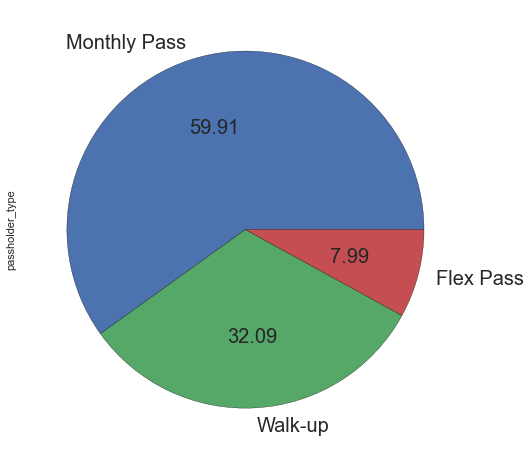

In [4]:
trip_data["passholder_type"].value_counts().plot.pie(subplots=True,figsize=(8,8),autopct='%.2f',fontsize=20);

We interest in the overall trip's duration. It is heavily right skewed. At 90th percentile, the trip duration is 2040 seconds( 34 minutes).

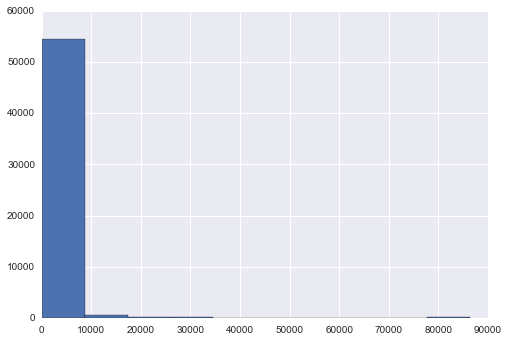

In [5]:
plt.hist(trip_data["duration"]);

In [6]:
trip_data["duration"].describe()

count    55439.000000
mean      1436.717473
std       4956.911177
min        120.000000
25%        420.000000
50%        660.000000
75%       1140.000000
max      86400.000000
Name: duration, dtype: float64

In [7]:
trip_data["duration"].median()

660.0

In [8]:
duration_90 = np.percentile(trip_data["duration"],90)
duration_90

2040.0

We plot Histogram of the overall trip's duration. To get a clearer view, the duration is capped 90th percentile.

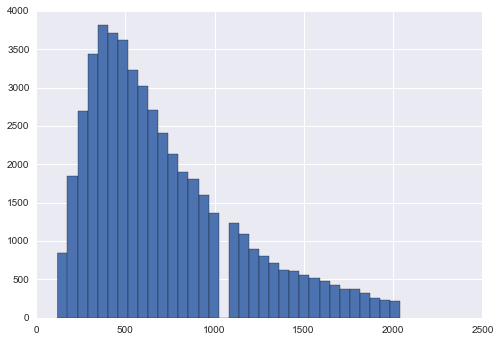

In [9]:
plt.hist(trip_data.loc[trip_data["duration"] <= duration_90,"duration"],bins=int(duration_90/60));

We interest in the revenue generated from all trips (see the [Pricing Options](https://bikeshare.metro.net/pricing/)). We ignore the initial subscription fee for Montly and Flex Pass since both data are not available. Firstly, we explore those trips that end within the first 30 minutes. We split the Histogram by a subscription type(Monthly Pass, Flex Pass, Walk-up).

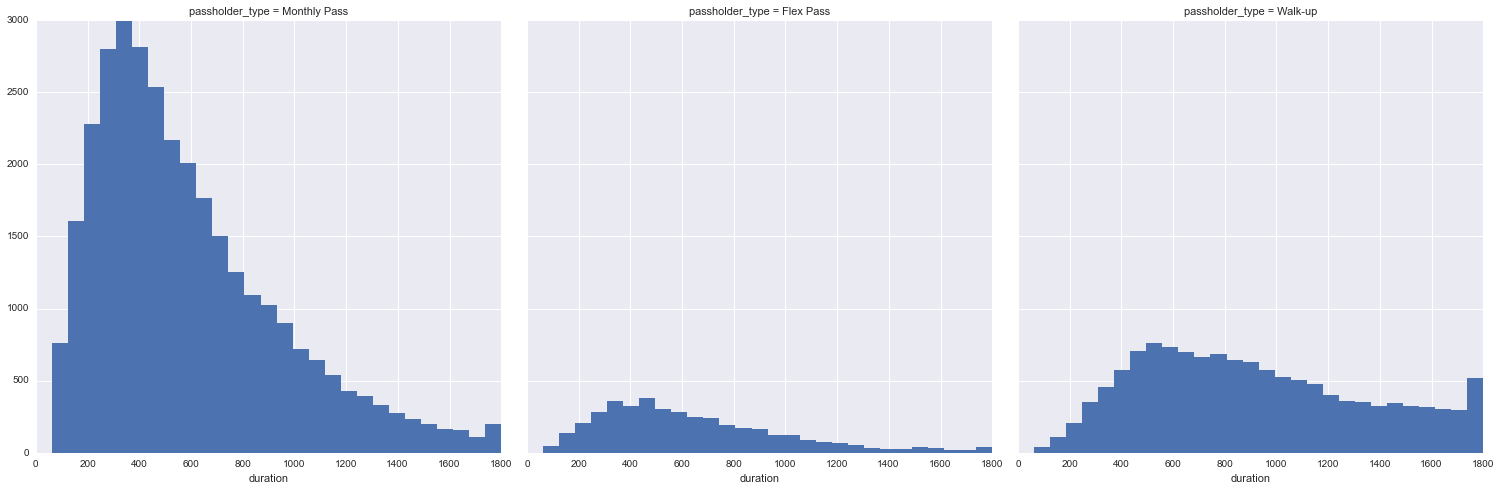

In [10]:
normal_data = trip_data.loc[trip_data["duration"] <= 1800]

g = sns.FacetGrid(data=normal_data,col="passholder_type",size=7)
g.map(plt.hist, "duration", lw=0, bins=np.linspace(0,1800,30));

For each additional 30 minutes, users will be incurred with an extra fee. We plot Histogram and investigate such trips. Most long trips were conducted by users with Walk-up subscription. As expected, they are more likely to be a visitor and spend more time exploring downtown LA.

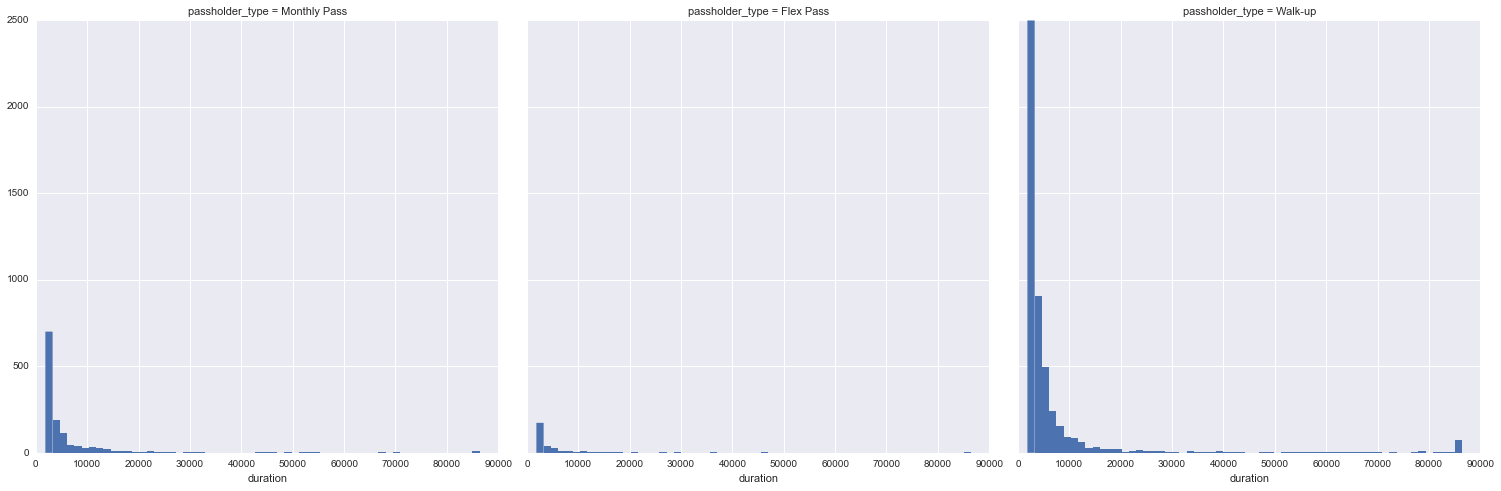

In [11]:
long_trip_data = trip_data.loc[trip_data["duration"] > 1800]

g = sns.FacetGrid(data=long_trip_data,col="passholder_type",size=7)
g.map(plt.hist, "duration", lw=0, bins=60);

In [12]:
long_trip_data.groupby("passholder_type")["duration"].median()

passholder_type
Flex Pass       3060
Monthly Pass    3060
Walk-up         3240
Name: duration, dtype: int64

In [13]:
long_trip_data.groupby("passholder_type")["duration"].count()

passholder_type
Flex Pass        321
Monthly Pass    1323
Walk-up         4922
Name: duration, dtype: int64

Next, we found that nearly 90% of trips are One-Way trip.

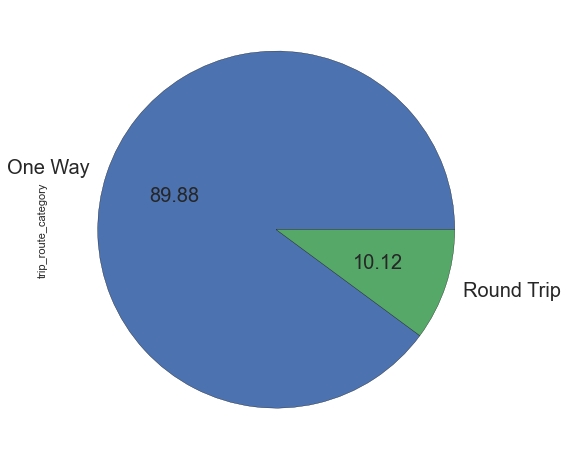

In [14]:
trip_data["trip_route_category"].value_counts().plot.pie(figsize=(8,8),autopct='%.2f',fontsize=20);

We facet the Pie Chart by a subscription type and found that a significantly more proportion of Round Trip is conducted by Walk-up users( 20%, compared to ~5% from Monthly and Flex Pass subscription). This aligns well with our earlier finding since Walk-up users spent more time traveling back and forth.

In [15]:
ct = pd.crosstab(trip_data["trip_route_category"],trip_data["passholder_type"])
ct

passholder_type,Flex Pass,Monthly Pass,Walk-up
trip_route_category,,,
One Way,4179,31488,14160
Round Trip,252,1728,3632


/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


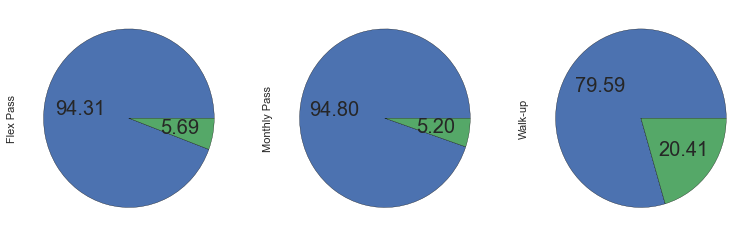

In [16]:
ct.plot.pie(subplots=True,figsize=(13,4),autopct='%.2f',fontsize=20,labels=None);


To prepare the data used in Tableau, we calculate revenue generated for each trip.

In [17]:
import math
from __future__ import division

In [18]:
def calculate_revenue(d):
    if d["passholder_type"] == "Walk-up":
        return (math.ceil(d["duration"]/1800) ) * 3.5
    elif d["passholder_type"] == "Flex Pass":
        return (math.ceil(d["duration"]/1800) ) * 1.75
    else:
        return (math.ceil(d["duration"]/1800) - 1 ) * 1.75
        

trip_data["revenue_gain"] = trip_data.apply(calculate_revenue,axis=1)

We also calculate a (typical) distance and travel time between each station. The usual route taken is calculated by GoogleMaps API. Noted: you need to install the GoogleMap API for Python via [this link](https://github.com/googlemaps/google-maps-services-python) and use your own API key.

In [19]:
import googlemaps

gmaps = googlemaps.Client(key='---Your API Key---')

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
trip_data["usual_distance"] = 0
trip_data["usual_duration"] = 0

start_end_dict = {}

We found that stationId "4108" has invalid lat/lon information. We simply drop rows that have station 4108 as either start or end station( 60 rows in total).

In [22]:
discard_rows = trip_data.loc[(trip_data["start_station_id"] == 4108) | (trip_data["end_station_id"] == 4108)]
discard_rows.shape

(60, 17)

In [23]:
discard_rows.head()

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,revenue_gain,usual_distance,usual_duration
235,2027211,180,7/8/2016 10:40,7/8/2016 10:43,4108,0.00000,0.00000,4108,0.0,0.0,6065,30,Round Trip,Monthly Pass,0.00,0,0
1463,2492936,9600,7/11/2016 15:08,7/11/2016 17:48,4108,0.00000,0.00000,4108,0.0,0.0,6286,30,Round Trip,Monthly Pass,8.75,0,0
1718,2614844,780,7/12/2016 9:38,7/12/2016 9:51,3079,34.05014,-118.23324,4108,0.0,0.0,6054,30,One Way,Monthly Pass,0.00,0,0
1781,2630413,120,7/12/2016 11:53,7/12/2016 11:55,4108,0.00000,0.00000,4108,0.0,0.0,6054,30,Round Trip,Monthly Pass,0.00,0,0
1975,2672199,1440,7/12/2016 15:57,7/12/2016 16:21,3079,34.05014,-118.23324,4108,0.0,0.0,6054,30,One Way,Monthly Pass,0.00,0,0


In [24]:
trip_data = trip_data.drop(discard_rows.index)

In [25]:
trip_data.shape

(55379, 17)

GoogleMaps API is limited as 2500 requests/day. We store the crawled data into a pickled file because we can't process all data in a single day.

In [26]:
import pickle
import os.path

if os.path.isfile("data/start_end_dict.p"):
    start_end_dict = pickle.load(open("data/start_end_dict.p","rb"))

In [ ]:
count = 0

def get_estimated_distance_and_time(d):
    global start_end_dict
    global count
    if d["trip_route_category"] == "Round Trip":
        return [0,0]
    
    start_id = d["start_station_id"]
    end_id = d["end_station_id"]
    start_end = (start_id,end_id)
        
    if start_end not in start_end_dict:
        try:
            print("Calling distance API for {}".format(start_end))
            map_info = gmaps.distance_matrix(origins=(d["start_lat"],d["start_lon"]),destinations=(d["end_lat"],d["end_lon"]),mode="bicycling")
            #dictionary hold (typical distance(metre),typical time taken(seconds))                                                                                         
            start_end_dict[start_end] = (map_info["rows"][0]["elements"][0]["distance"]["value"],map_info["rows"][0]["elements"][0]["duration"]["value"])    
            count += 1
            if count % 100 == 0:
                print("dump current retrieved data[{}]".format(count))
                pickle.dump(start_end_dict,open('data/start_end_dict.p','wb'))
        except:
            print("Can't retireve data for row:{}...".format(d))
            pickle.dump(start_end_dict,open('data/start_end_dict.p','wb'))
            #terminate the program to investigate further(likely, the limit is reached)
            raise
            
    return [start_end_dict[start_end][0],start_end_dict[start_end][1]]

trip_data.loc[0:,["usual_distance","usual_duration"]] = list(trip_data.apply(get_estimated_distance_and_time,axis=1))  
print("finish calling GoogleMaps API...")    

In [74]:
#check with GoogleMaps website that usual_distace and usual_duration is processed correctly
trip_data.head(10)

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,revenue_gain,usual_distance,usual_duration
0,1912818,180,7/7/2016 4:17,7/7/2016 4:20,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass,0.00,0,0
1,1919661,1980,7/7/2016 6:00,7/7/2016 6:33,3014,34.056610,-118.23721,3014,34.056610,-118.23721,6281,30,Round Trip,Monthly Pass,1.75,0,0
2,1933383,300,7/7/2016 10:32,7/7/2016 10:37,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass,1.75,0,0
3,1944197,10860,7/7/2016 10:37,7/7/2016 13:38,3016,34.052898,-118.24156,3016,34.052898,-118.24156,5861,365,Round Trip,Flex Pass,12.25,0,0
4,1940317,420,7/7/2016 12:51,7/7/2016 12:58,3032,34.049889,-118.25588,3032,34.049889,-118.25588,6674,0,Round Trip,Walk-up,3.50,0,0
5,1944075,780,7/7/2016 12:51,7/7/2016 13:04,3021,34.045609,-118.23703,3054,34.039219,-118.23649,6717,30,One Way,Monthly Pass,0.00,995,263
6,1944073,600,7/7/2016 12:54,7/7/2016 13:04,3022,34.046070,-118.23309,3014,34.056610,-118.23721,5721,30,One Way,Monthly Pass,0.00,1779,394
7,1944067,600,7/7/2016 12:59,7/7/2016 13:09,3076,34.040600,-118.25384,3005,34.048550,-118.25905,5957,365,One Way,Flex Pass,1.75,1468,510
8,1944062,2880,7/7/2016 13:01,7/7/2016 13:49,3031,34.044701,-118.25244,3031,34.044701,-118.25244,6137,365,Round Trip,Flex Pass,3.50,0,0
9,1944063,960,7/7/2016 13:01,7/7/2016 13:17,3031,34.044701,-118.25244,3078,34.064281,-118.23894,6351,30,One Way,Monthly Pass,0.00,3102,904


In [72]:
trip_data.tail()

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,revenue_gain,usual_distance,usual_duration
55434,8365125,840,9/30/2016 23:43,9/30/2016 23:57,3054,34.039219,-118.23649,3005,34.048550,-118.25905,6146,30,One Way,Monthly Pass,0.0,2863,807
55435,8369653,840,9/30/2016 23:44,9/30/2016 23:58,3051,34.045422,-118.25352,3055,34.044159,-118.25158,6069,30,One Way,Monthly Pass,0.0,228,81
55436,8369652,1020,9/30/2016 23:47,10/1/2016 0:04,3032,34.049889,-118.25588,3023,34.050911,-118.24097,5725,0,One Way,Walk-up,3.5,2064,605
55437,8369651,540,9/30/2016 23:53,10/1/2016 0:02,3035,34.048401,-118.26095,3031,34.044701,-118.25244,5975,0,One Way,Walk-up,3.5,1009,290
55438,8369650,480,9/30/2016 23:54,10/1/2016 0:02,3035,34.048401,-118.26095,3031,34.044701,-118.25244,6683,0,One Way,Walk-up,3.5,1009,290


Then, we store the processed data and switch to Tableau for Explanatory Analysis.

In [73]:
trip_data.to_csv("data/processed.csv",index=False)